# Random Forest Model tuning

Let's see how much improvement can be made on a default random forest model via hyperparameter optimization. We'll work most of our tuning on 10% sample of the entire training set. 

# Set up

In [38]:
import pandas as pd
import zipfile 
from zipfile import ZipFile 
import pickle
pandas.set_option("future.no_silent_downcasting", True)

file_name = "playground-series-s4e7.zip"
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir()
df_zip = zipfile.ZipFile(file_name)
train = pd.read_csv(df_zip.open('train.csv'))

# import sample
import random

n = len(train) # Calculate number of rows in file
s = n//10  # sample size of 10%
skip = sorted(random.sample(range(1, n+1), n-s))   
train_sample = pd.read_csv(df_zip.open('train.csv'), skiprows = skip)
train_sample


File Name                                             Modified             Size
sample_submission.csv                          2024-06-24 13:46:18     99708270
test.csv                                       2024-06-24 13:46:24    433918183
train.csv                                      2024-06-24 13:46:48    662779095


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,7,Female,47,1,8.0,0,1-2 Year,Yes,40659.0,26.0,262,1
1,14,Female,24,1,12.0,1,< 1 Year,No,23692.0,152.0,245,0
2,75,Female,46,1,33.0,1,1-2 Year,No,26928.0,26.0,262,0
3,101,Female,40,1,28.0,0,1-2 Year,Yes,42903.0,26.0,110,0
4,112,Female,49,1,18.0,0,1-2 Year,Yes,2630.0,26.0,81,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1150474,11504740,Male,39,1,46.0,0,1-2 Year,Yes,28887.0,91.0,183,0
1150475,11504742,Male,61,1,28.0,1,1-2 Year,No,39470.0,26.0,130,0
1150476,11504748,Male,63,1,19.0,0,1-2 Year,Yes,34870.0,26.0,288,0
1150477,11504750,Female,28,1,36.0,0,< 1 Year,No,36303.0,152.0,227,0


In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 1.0+ GB


 # Reduce Memory

To reduce memory load we'll change some column types to more memory-friendly formats. 

In [40]:
# drop id
train = train.drop('id', axis = 1)

# convert obj to cat
categorical = ["Region_Code", "Policy_Sales_Channel", "Gender", "Vehicle_Damage", "Vehicle_Age"]
train[["Region_Code", "Policy_Sales_Channel"]] = train[["Region_Code", "Policy_Sales_Channel"]].astype('int32')
train[categorical] = train[categorical].astype("category")

# train sample
train[["Region_Code", "Policy_Sales_Channel"]] = train[["Region_Code", "Policy_Sales_Channel"]].astype('int32')
train[categorical] = train[categorical].astype("category")

# convert numerics into int 32 

import numpy as np
# integer
d = dict.fromkeys(train.select_dtypes(np.int64).columns, np.int32)
train = train.astype(d)

# float
d2 = dict.fromkeys(train.select_dtypes(np.float64).columns, np.int32)
train = train.astype(d2)

## Sample

In [41]:
train_sample = train_sample.drop('id', axis = 1)

# convert obj to cat
train_sample[["Region_Code", "Policy_Sales_Channel"]] = train_sample[["Region_Code", "Policy_Sales_Channel"]].astype('int64')
train_sample[categorical] = train_sample[categorical].astype("category")

# train_sample sample
train_sample[["Region_Code", "Policy_Sales_Channel"]] = train_sample[["Region_Code", "Policy_Sales_Channel"]].astype('int64')
train_sample[categorical] = train_sample[categorical].astype("category")

# convert numerics into int 32 

import numpy as np
# integer
d = dict.fromkeys(train_sample.select_dtypes(np.int64).columns, np.int64)
train_sample = train_sample.astype(d)

# float
d2 = dict.fromkeys(train_sample.select_dtypes(np.float64).columns, np.int64)
train_sample = train_sample.astype(d2)


# Split

In [42]:
from sklearn.model_selection import train_test_split
X = train.drop("Response", axis = 1)
y = train["Response"]


X_train, X_val, y_train, y_val = train_test_split(X,y,
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    stratify = y)

## Sample

In [43]:
Xs = train_sample.drop("Response", axis = 1)
ys = train_sample["Response"]


Xs_train, Xs_val, ys_train, ys_val = train_test_split(Xs,ys,
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    stratify = ys)

# Preprocessing

## Column groups

In [44]:
unique_values = Xs_train.select_dtypes(include = ['object', 'category']).nunique()

binary_cat = unique_values.index[unique_values == 2].tolist()
ordinal_cat = ["Vehicle_Age"]
target_cat = unique_values.index[unique_values > 20].tolist()
categorical = Xs_train.select_dtypes(include = ['object', 'category']).columns.values.tolist()
categorical.remove("Vehicle_Age")
nominal_cat = list(set(categorical).difference(binary_cat))

vehicle_age_categories = ['< 1 Year', '1-2 Year', '> 2 Years']

# numerical transformer
num_col = ['Age','Annual_Premium','Vintage']


## Encoders

In [45]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from category_encoders import BinaryEncoder

# ordinal encoder
ordinal = Pipeline(steps=[
    ("ordinal", OrdinalEncoder(categories=[['< 1 Year', '1-2 Year', '> 2 Years']])),
])
# target encoder
target = Pipeline(steps=[
    ("target", TargetEncoder()),
])

# ohe encoder
ohe  = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown= 'ignore')),
])

# dummy encoder
binary = Pipeline(steps=[
    ("dummy",BinaryEncoder()),
])

num_pipe = Pipeline(steps=[
    ("standardize", StandardScaler()) # standardize
])


## Preprocessing pipe

In [46]:
from sklearn.compose import ColumnTransformer

default = ColumnTransformer(
    transformers=[
        ("ord", ordinal, ordinal_cat),
        ("dummy", binary, binary_cat),
        ("num", num_pipe, num_col),
        ("target",target, nominal_cat)
    ],
    remainder = "passthrough"
    
)

In [47]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(verbose = 2, n_jobs = -1, random_state = 42,class_weight = "balanced_subsample") 

default_rf = Pipeline(steps=[
          ('column_tran',default),
          ('model',rf)
     ])

In [48]:
default_rf.fit(Xs_train, ys_train)
pred_default_rf = default_rf.predict(Xs_val)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/category_encoders/

building tree 1 of 100building tree 2 of 100
building tree 3 of 100
building tree 4 of 100

building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100building tree 15 of 100
building tree 16 of 100

building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100building tree 23 of 100

building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100building tree 28 of 100
building tree 29 of 100
building tree 30 of 100

building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   29.0s


building tree 34 of 100building tree 35 of 100

building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100building tree 69 of 100

building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
[Parallel(n_jobs=8)]: Using

# Default model

## Performance

In [81]:
from sklearn.metrics import precision_score,accuracy_score,recall_score,f1_score, roc_auc_score
def return_eval(pred, eval):
    acc = accuracy_score(eval,pred)
    ps = precision_score(eval, pred)
    rec = recall_score(eval,pred)
    f1 = f1_score(eval, pred)
    auc = roc_auc_score(eval, pred)
    return acc , ps ,rec, f1, auc
default_metric = return_eval(pred_default_rf, ys_val)
default_metric

(0.8681333008831097,
 0.3995709828393136,
 0.14489781486457817,
 0.21267320566713374,
 0.5571922849977702)

In [50]:
default_rf['model'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 2,
 'warm_start': False}

Our default random forest has a 86.7% accuracy, a little lower than our naive model run. Looking back, I believe that both nominal variables (Policy_Sales_Channel, Region_Code) were both ignored in the previous notebook. This performance difference is likely due to our explicit target-encoding of these two variables. Let's look at other details of the default.

## Depth

avg max depth 63.3


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

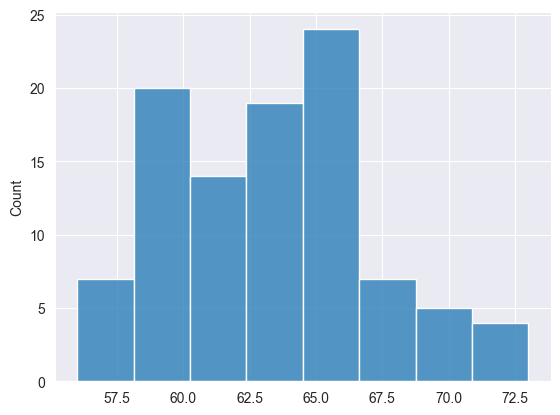

In [51]:
max_depth = list()

for tree in default_rf['model'].estimators_:
    max_depth.append(tree.tree_.max_depth)

print("avg max depth %0.1f" % (sum(max_depth) / len(max_depth)))

import seaborn as sns
sns.histplot(data = max_depth)

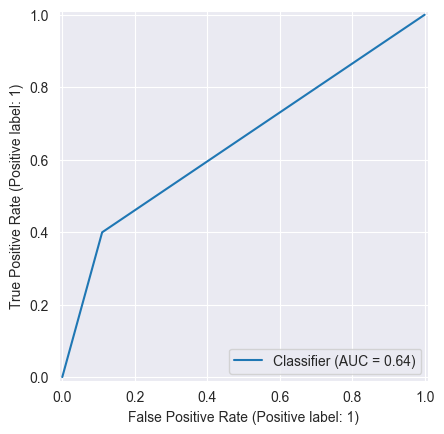

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_predictions(pred_default_rf, ys_val, ax=ax)
plt.show()

In [53]:
global_importances = pd.Series(default_rf['model'].feature_importances_, index=default_rf['column_tran'].get_feature_names_out())
global_importances.reset_index()

,index,0
0,ord__Vehicle_Age,0.021931
1,dummy__Gender_0,0.002485
2,dummy__Gender_1,0.002353
3,dummy__Vehicle_Damage_0,0.107775
4,dummy__Vehicle_Damage_1,0.123457
5,num__Age,0.112696
6,num__Annual_Premium,0.179479
7,num__Vintage,0.188867
8,target__Region_Code,0.073761
9,target__Policy_Sales_Channel,0.087751


In [54]:
importance_df  =global_importances.reset_index().rename(columns = {0:'values'}).sort_values(by = 'values')

Text(0, 0.5, 'Features')

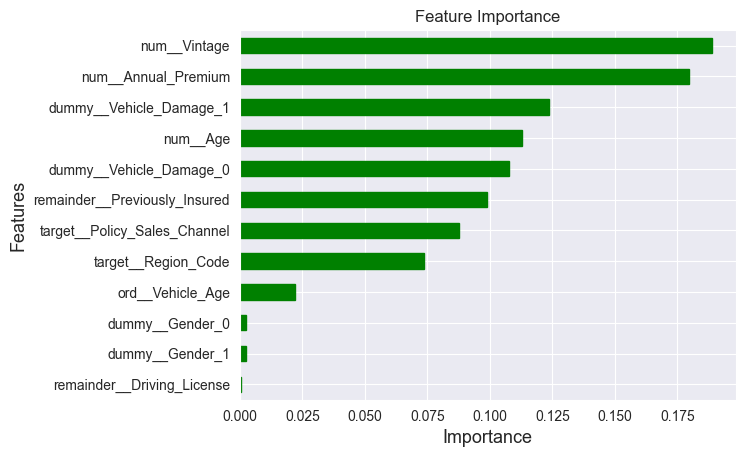

In [55]:
importance_df.plot.barh(x = 'index', y = 'values', color="green", edgecolor='green',legend=False)
plt.title("Feature Importance")
plt.xlabel("Importance", fontsize=13)
plt.ylabel("Features", fontsize=13)

# Model tuning

Now that we have our baseline random forest model, let's try tuning a model and see if it does better! Hyperoptimization can be done in several ways, including but not limited to:
- Grid search: We specify a finite set of values for each hyperparameter and the grid search evaluates a cartesian product of these values. The method is limited to the values we define and since the grid search evaluates all combinations, this method suffers from dimensionality of our hyperparameter space.
- Random search: We also specify a finite set of values. However, random search will evaluate combinations, well, randomly until a stopping criteria is met. This is useful for trying out varying combinations of our hypothesized values to test what seems to work. This is typically be used to start an optimization process by finding promising values and then fine-tuning with a grid search around those initial values. 
- Bayesian Optimization: We define a range of hyperparameter values and this method uses a function to determine which combination to test each round. Specifically, we define an 'objective' function (eg accuracy) that is then approximated by Bayesian Optimizer as a probability model. This probability model is then used to estimate the next selections of hyperparameters values that yield the highest Expected Improvement. If you want to learn more about how this is done, you can check out Tree Parzen Estimators (TPE)(https://towardsdatascience.com/bayesian-optimization-concept-explained-in-layman-terms-1d2bcdeaf12f) and the (Hyperopt)[https://hyperopt.github.io/hyperopt/ ] documentation.



## Bayesian Optimization

For a brief taste of how hyperparameter tuning using bayesian optimization works, this code snippet below runs 10 trials to optimize accuracy with an early round stop of 3. Each trial tests a combination of pre-defined parameter `space` and produces a set of evaluation metric I have asked for (accuracy, precision, recall, auc, f1). However, this is just a snippet to allow replication. Hyperopt actually uses the first 20 rounds to "warm up" and it uses random combinations to test the parameter space. The real modeling requires tens, hundreds of rounds to really find optimizations. I have tested custom loss equations (accuracy + auc, recall + accuracy) and different number of evaluation trials (200, stopped at 70).

In [57]:
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin, STATUS_FAIL, space_eval
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.early_stop import no_progress_loss
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import cross_validate, StratifiedKFold
import numpy as np


Xs_trans = default.transform(Xs_train)
space = {'criterion': hp.choice('criterion', [ 'gini']),
        'max_depth': hp.choice('max_depth', np.arange(20, 120,dtype=int)),
        'max_features': hp.choice('max_features', ['sqrt','log2',0.25,.5,.75, None]),
        'min_samples_leaf': hp.uniform ('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', np.arange(100, 1000 ,dtype=int))
    }

def objective(space):
    model = RandomForestClassifier(criterion = space['criterion'], 
                                   n_jobs = -1, random_state = 42,
                                   class_weight = 'balanced_subsample',
                                   max_depth = space['max_depth'],
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'], 
                                 )
    cv = StratifiedKFold(n_splits=4)
    scoring = {'prec_macro': 'precision_macro',
               'accuracy': 'accuracy',
               'rec_macro': 'recall_macro',
               'auc':'roc_auc',
               'f1_macro':'f1_macro'}
    scores = cross_validate(model, Xs_trans, ys_train, scoring=scoring,
                            cv=cv)
    accuracy = scores['test_accuracy'].mean()
    precision = scores['test_prec_macro'].mean()
    recall = scores['test_rec_macro'].mean()
    f1 = scores['test_f1_macro'].mean()
    auc = scores['test_auc'].mean()
    loss = -accuracy
    
    return {'loss': loss, 'status': STATUS_OK , 'accuracy': accuracy, 'precision': precision, 'recall': recall,'f1':f1,
            'auc':auc}
            
    
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 10,
            early_stop_fn=no_progress_loss(3),
            trials= trials)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)


  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 10%|█         | 1/10 [02:06<18:54, 126.03s/trial, best loss: -0.6885420899430046]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 30%|███       | 3/10 [11:26<30:04, 257.72s/trial, best loss: -0.8770870387684897]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 50%|█████     | 5/10 [18:36<18:36, 223.22s/trial, best loss: -0.8770870387684897]


In [59]:
best

{'criterion': 0,
 'max_depth': 67,
 'max_features': 2,
 'min_samples_leaf': 0.37586589603181564,
 'min_samples_split': 0.9939426378037503,
 'n_estimators': 374}

## Trial results

In [60]:
trials.results

[{'loss': -0.6885420899430046,
  'status': 'ok',
  'accuracy': 0.6885420899430046,
  'precision': 0.3442710449715023,
  'recall': 0.5,
  'f1': 0.377808727228793,
  'auc': 0.5},
 {'loss': -0.8770870387684897,
  'status': 'ok',
  'accuracy': 0.8770870387684897,
  'precision': 0.43854351938424485,
  'recall': 0.5,
  'f1': 0.4672596532034825,
  'auc': 0.5},
 {'loss': -0.6788728181668776,
  'status': 'ok',
  'accuracy': 0.6788728181668776,
  'precision': 0.6286459121091863,
  'recall': 0.7924910357573517,
  'f1': 0.598676397297732,
  'auc': 0.8392015906551122},
 {'loss': -0.8770870387684897,
  'status': 'ok',
  'accuracy': 0.8770870387684897,
  'precision': 0.43854351938424485,
  'recall': 0.5,
  'f1': 0.4672596532034825,
  'auc': 0.5},
 {'loss': -0.6157632215060238,
  'status': 'ok',
  'accuracy': 0.6157632215060238,
  'precision': 0.6180710343281364,
  'recall': 0.7737947704953825,
  'f1': 0.5532645708029039,
  'auc': 0.7737947704953825}]

## Trials EDA

In [61]:
def unpack(x):
    if x:
        return x[0]
    return np.nan


# We'll first turn each trial into a series and then stack those series together as a dataframe.
trials_df = pd.DataFrame([pd.Series(t["misc"]["vals"]).apply(unpack) for t in trials])

In [62]:

# Then we'll add other relevant bits of information to the correct rows and perform a couple of
# mappings for convenience
trials_df["loss"] = [t["result"]["loss"] for t in trials]
trials_df["accuracy"] = [t["result"]["accuracy"] for t in trials]
trials_df["precision"] = [t["result"]["precision"] for t in trials]
trials_df["recall"] = [t["result"]["recall"] for t in trials]
trials_df["f1"] = [t["result"]["f1"] for t in trials]
trials_df["auc"] = [t["result"]["auc"] for t in trials]
trials_df["trial_number"] = trials_df.index



In [63]:
trials_df

,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,loss,accuracy,precision,recall,f1,auc,trial_number
0,0.0,18.0,4.0,0.045795,0.891790,239.0,-0.688542,0.688542,0.344271,0.500000,0.377809,0.500000,0
1,0.0,67.0,2.0,0.375866,0.993943,374.0,-0.877087,0.877087,0.438544,0.500000,0.467260,0.500000,1
2,0.0,96.0,2.0,0.102586,0.192436,349.0,-0.678873,0.678873,0.628646,0.792491,0.598676,0.839202,2
3,0.0,90.0,5.0,0.350661,0.775052,408.0,-0.877087,0.877087,0.438544,0.500000,0.467260,0.500000,3
4,0.0,18.0,5.0,0.275117,0.519044,46.0,-0.615763,0.615763,0.618071,0.773795,0.553265,0.773795,4


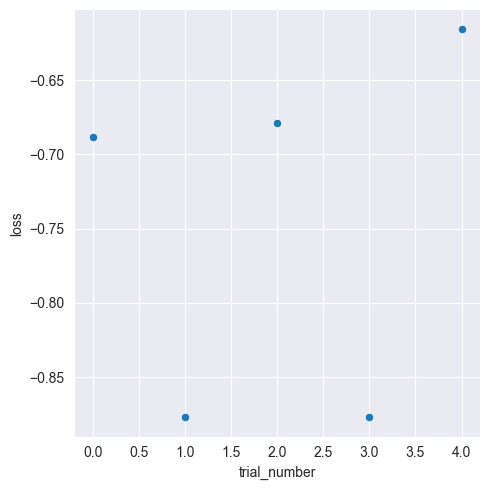

In [64]:
sns.relplot(trials_df, x = "trial_number", y = "loss")

In [71]:
trials_df['trial_number']  = trials_df['trial_number'].astype("int")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_ol

Text(0, 0.5, 'value')

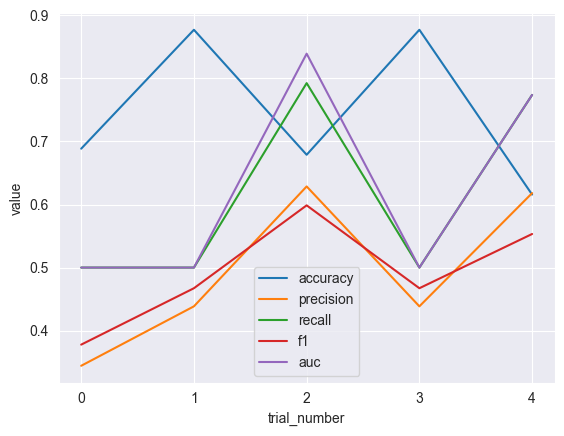

In [75]:

for i in ['accuracy','precision','recall','f1', 'auc']:
    sns.lineplot(x="trial_number", y=i, data=trials_df, label = str(i))
plt.xticks(range(0,5))
plt.ylabel('value')

# Accuracy tuned model - brief

In [76]:
best_params = best.copy()
best_params.pop('criterion')

0

In [77]:
rf_tuned_initial = RandomForestClassifier( n_jobs = -1, random_state = 42,
                                   class_weight = 'balanced_subsample', **best_params, criterion = 'gini')

In [78]:
tuned_rf = Pipeline(steps=[
          ('column_tran',default),
          ('model',rf_tuned_initial)
     ])
tuned_rf.fit(Xs_train, ys_train)
pred_tuned_rf = tuned_rf.predict(Xs_val)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/category_encoders/

In [79]:
def return_eval(pred, eval):
    acc = accuracy_score(eval,pred)
    ps = precision_score(eval, pred)
    rec = recall_score(eval,pred)
    f1 = f1_score(eval, pred)
    auc = roc_auc_score(eval, pred)
    return acc , ps ,rec, f1, auc

return_eval(pred_tuned_rf, ys_val)

(0.12291391419233712, 0.12291391419233712, 1.0, 0.2189195674554335, 0.5)

The model is not significantly better than our default random forest classifier. This is not surprising given that we only allowed for 10 iterations and the optimizer simply uses a random grid search during the first 20 rounds. Let's see if our model that ran for 70 rounds performed better.

# Accuracy tuned - 200 rounds

In [21]:
trials_200 = pd.read_csv('trials.csv')
trials_200.sort_values(by = 'accuracy', ascending= False)

,Unnamed: 0,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,loss,trial_number,accuracy,precision,recall,f1,auc
44,44,0.0,64.0,4.0,0.001203,0.215710,255.0,0.294162,44,0.705838,0.634241,0.797880,0.618050,0.850588
30,30,0.0,2.0,0.0,0.000863,0.092020,81.0,0.297172,30,0.702828,0.633832,0.798039,0.616083,0.851013
55,55,0.0,25.0,3.0,0.000884,0.203873,856.0,0.298231,55,0.701769,0.633582,0.797788,0.615310,0.850679
34,34,0.0,42.0,2.0,0.009476,0.247936,562.0,0.298588,34,0.701412,0.632941,0.796260,0.614661,0.843894
32,32,0.0,37.0,0.0,0.007479,0.160020,806.0,0.298917,32,0.701083,0.633527,0.797894,0.614882,0.849058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,18,0.0,57.0,3.0,0.373254,0.314609,274.0,0.575389,18,0.424611,0.212306,0.500000,0.252631,0.500000
5,5,0.0,23.0,1.0,0.005949,0.721384,161.0,0.575389,5,0.424611,0.212306,0.500000,0.252631,0.500000
49,49,0.0,76.0,3.0,0.342647,0.130582,94.0,0.726166,49,0.273834,0.136917,0.500000,0.181102,0.500000
17,17,0.0,34.0,5.0,0.121750,0.741832,21.0,0.726166,17,0.273834,0.136917,0.500000,0.181102,0.500000


In [88]:
best_200 = trials_200[trials_200['trial_number']==44]
best_200

,Unnamed: 0,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,loss,trial_number,accuracy,precision,recall,f1,auc
44,44,0.0,64.0,4.0,0.001203,0.21571,255.0,0.294162,44,0.705838,0.634241,0.79788,0.61805,0.850588


In [89]:
remove = ['Unnamed: 0', 'criterion', 'loss', 'trial_number', 'accuracy', 'precision', 'recall', 'f1', 'auc']
best_200_params = best_200.to_dict(orient = 'records')[0]
for i in remove:
    best_200_params.pop(i)

In [90]:
for i in ['max_depth', 'n_estimators', 'max_features']:
        best_200_params[i] = int(best_200_params[i])
best_200_params

{'max_depth': 64,
 'max_features': 4,
 'min_samples_leaf': 0.0012025420150464,
 'min_samples_split': 0.2157102541161757,
 'n_estimators': 255}

In [91]:
rf_tuned_200 = RandomForestClassifier( n_jobs = -1, random_state = 42,
                                   class_weight = 'balanced_subsample', **best_200_params, criterion = 'gini')

In [92]:
tuned_rf_200 = Pipeline(steps=[
    ('column_tran', default),
    ('model', rf_tuned_200)
])
tuned_rf_200.fit(Xs_train, ys_train)
pred_tuned_rf_200 = tuned_rf_200.predict(Xs_val)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/category_encoders/

In [93]:
rf_200_metric = return_eval(pred_tuned_rf_200, ys_val)
rf_200_metric

(0.7000556289548711,
 0.2811929266668099,
 0.9254649600452585,
 0.43133054282983424,
 0.7969659821582591)

In [102]:
eval_metric = ['accuracy', 'precision', 'recall', 'f1', 'auc']
metric = pd.DataFrame({'name':eval_metric, 'default':default_metric,'rf_200':rf_200_metric })
metric['percent change'] = (  metric['rf_200'] - metric['default'] )/metric['default'] * 100
metric

,name,default,rf_200,percent change
0,accuracy,0.868133,0.700056,-19.360814
1,precision,0.399571,0.281193,-29.626290
2,recall,0.144898,0.925465,538.701806
3,f1,0.212673,0.431331,102.813768
4,auc,0.557192,0.796966,43.032487


It looks like overall accuracy came down to 70% but recall and auc increased significantly. We traded off a 20% decrease in accuracy to improve recall by 500%, f1 by 100%, and auc by 40%.